In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from utils import PkdbModel, caffeine_idx, measurement_type_data, filter_out, convert_unit, unstring
plt.style.use('seaborn-whitegrid')
import numpy as np

{'token': '9aab6e76a4bd5cb4b8bc58653b9434a3f5f00e3d'}


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
def to_numeric(df_data):
    df_data[("weight","value")] = pd.to_numeric(df_data[("weight","value")])
    df_data[("weight","mean")] = pd.to_numeric(df_data[("weight","mean")])
    df_data["value_intervention"] = pd.to_numeric(df_data["value_intervention"])
    df_data["median"] = pd.to_numeric(df_data["median"])
    df_data["mean"] = pd.to_numeric(df_data["mean"])
    df_data["value"] = pd.to_numeric(df_data["value"])
    df_data["se"] = pd.to_numeric(df_data["se"])
    df_data["sd"] = pd.to_numeric(df_data["sd"])
    df_data["cv"] = pd.to_numeric(df_data["cv"])
    return df_data
     
def infer_from_interventions(data, unit_abs = "gram"):
    unit_rel= unit_abs + " / kilogram"
    data_rel = convert_unit(data,
                             unit_in=unit_abs,
                             unit_out=unit_rel, 
                             factor=1.0/data[("weight","value")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'], 
                             subset=[("weight","value"),"value"])

    data_abs = convert_unit(data,
                             unit_in=unit_rel,
                             unit_out=unit_abs, 
                             factor=data[("weight","value")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'],
                             subset=[("weight","value"),"value"])
    data_rel["inferred"] = True
    data_abs["inferred"] = True

    
    data = pd.concat([data,data_rel,data_abs], ignore_index=True)
    
    data_rel = convert_unit(data,
                             unit_in=unit_abs,
                             unit_out=unit_rel, 
                             factor=1.0/data[("weight","mean")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'], 
                             subset=[("weight","mean"),"mean"])

    data_abs = convert_unit(data,
                             unit_in=unit_rel,
                             unit_out=unit_abs, 
                             factor=data[("weight","mean")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'],
                             subset=[("weight","mean"),"mean"])
    data_rel["inferred"] = True
    data_abs["inferred"] = True
    
    data = pd.concat([data,data_rel,data_abs], ignore_index=True)
    
    return data

def infer_from_outputs(data, unit_abs="liter / hour"):
    unit_rel= unit_abs + " / kilogram"
    data_rel = convert_unit(data,
                                 unit_in=unit_abs,
                                 unit_out=unit_rel, 
                                 factor=1.0/data[("weight","value")],
                                 unit_field="unit", 
                                 data_fields=['value'], 
                                 subset=[("weight","value"),"value"])

    data_abs_i = convert_unit(data,
                                 unit_in=unit_rel,
                                 unit_out=unit_abs, 
                                 factor=data[("weight","value")],
                                 unit_field="unit", 
                                 data_fields=['value'],
                                 subset=[("weight","value"),"value"])
    data_rel["inferred"] = True
    data_abs_i["inferred"] = True
    

    data = pd.concat([data,data_rel,data_abs_i], ignore_index=True)
    
    data_rel = convert_unit(data,
                             unit_in=unit_abs,
                             unit_out=unit_rel, 
                             factor=1.0/data[("weight","mean")],
                             unit_field="unit", 
                             data_fields=['mean','median','sd', 'se'],
                             subset=[("weight","mean"),"mean"])

    data_abs = convert_unit(data,
                             unit_in=unit_rel,
                             unit_out=unit_abs, 
                             factor=data[("weight","mean")],
                             unit_field="unit", 
                             data_fields=['mean','median','sd', 'se'],
                             subset=[("weight","mean"),"mean"])
    
    data_rel["inferred"] = True
    data_abs["inferred"] = True


    data = pd.concat([data,data_rel,data_abs], ignore_index=True)
    
    return data

In [4]:
all_complete = PkdbModel("all_complete", destination="2-merged")
all_complete.read()
all_complete.data.loc[(all_complete.data[("sex","choice")] == "M"),("oral contraceptives","choice")] = "N"
complete_caffeine = all_complete.data[caffeine_idx(all_complete.data)]
complete_caffeine["inferred"] = False

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (12,16,19,22,23,24,25,26,27,28,29,30,31,44,71,72,113,114,115,117,119,121,123,124,126,127,128,129,130,131,132,133,134,136,140,142,146,147,149,150,151,153,154,167,168,169,170,171,178,180,181,182,183,185,186,188,190,192,198,199,200,207,208,212,215,216,224,229,233,234,239,243) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [5]:
caffeine_clearance = measurement_type_data(complete_caffeine,"clearance")
caffeine_clearance = filter_out(caffeine_clearance,"unit",["milliliter / meter ** 2 / minute"])

In [6]:
caffeine_clearance.groupby(["unit"]).apply(len)

unit
liter / hour               338
liter / hour / kilogram    409
dtype: int64

In [7]:
caffeine_clearance = to_numeric(caffeine_clearance)
caffeine_clearance = infer_from_interventions(caffeine_clearance,"gram")
caffeine_clearance = infer_from_outputs(caffeine_clearance,"liter / hour")
caffeine_clearance.groupby("inferred").apply(len)

inferred
False     747
True     1212
dtype: int64

In [8]:
caffeine_clearance = convert_unit(caffeine_clearance,unit_in="liter / hour",unit_out="ml/min", factor=1000.0/60,data_fields=['mean','median','sd', 'se','value'])
caffeine_clearance = convert_unit(caffeine_clearance,unit_in="gram",unit_out="mg", factor=1000.0,data_fields=['value_intervention'],unit_field="unit_intervention")

caffeine_clearance = convert_unit(caffeine_clearance,unit_in="liter / hour / kilogram",unit_out="ml/min/kg", factor=1000.0/60,data_fields=['mean','median','sd', 'se','value'])
caffeine_clearance = convert_unit(caffeine_clearance,unit_in="gram / kilogram",unit_out="mg/kg", factor=1000.0,data_fields=['value_intervention'],unit_field="unit_intervention")


In [9]:
caffeine_clr = PkdbModel("caffeine_clearance",destination="3-inferred")
caffeine_clr.data = caffeine_clearance
caffeine_clr.save()

In [10]:
caffeine_clearance.groupby(["unit", "unit_intervention"]).apply(len)

unit       unit_intervention
ml/min     mg                   574
           mg/kg                404
ml/min/kg  mg                   556
           mg/kg                425
dtype: int64

In [11]:
caffeine_clearance.groupby(["calculated"]).apply(len)

calculated
False    1737
True      222
dtype: int64

## Timecourses

In [12]:
caffeine_timecourse = measurement_type_data(complete_caffeine,"concentration")
caffeine_timecourse = filter_out(caffeine_timecourse,"output_type",["outputs"])


In [13]:
caffeine_timecourse.groupby(["unit","unit_intervention","inferred"]).count()

study  output_type   pk  access  \
unit         unit_intervention inferred                                    
gram / liter gram              False       105          105  105     105   
             gram / kilogram   False        23           23   23      23   
mole / liter gram              False         5            5    5       5   
             gram / kilogram   False        12           12   12      12   

                                         measurement_type  tissue  \
unit         unit_intervention inferred                             
gram / liter gram              False                  105     105   
             gram / kilogram   False                   23      23   
mole / liter gram              False                    5       5   
             gram / kilogram   False                   12      12   

                                         allowed_users  substance  raw_pk  \
unit         unit_intervention inferred                                     
gram / liter gram              False               105        105     105   
             gram / kilogram   False                23         23      23   
mole / liter gram              False                 5          5       5   
             gram / kilogram   False                12         12      12   

                                         interventions  ...  \
unit         unit_intervention inferred                 ...   
gram / liter gram              False               105  ...   
             gram / kilogram   False                23  ...   
mole / liter gram              False                 5  ...   
             gram / kilogram   False                12  ...   

                                         (cyp2d6 variant, choice)  \
unit         unit_intervention inferred                             
gram / liter gram              False                            0   
             gram / kilogram   False                            0   
mole / liter gram              False                            0   
             gram / kilogram   False                            0   

                                         (cyp2d6 variant, count)  \
unit         unit_intervention inferred                            
gram / liter gram              False                           0   
             gram / kilogram   False                           0   
mole / liter gram              False                           0   
             gram / kilogram   False                           0   

                                         (lean body mass, count)  \
unit         unit_intervention inferred                            
gram / liter gram              False                           0   
             gram / kilogram   False                           0   
mole / liter gram              False                           0   
             gram / kilogram   False                           0   

                                         (lean body mass, mean)  \
unit         unit_intervention inferred                           
gram / liter gram              False                          0   
             gram / kilogram   False                          0   
mole / liter gram              False                          0   
             gram / kilogram   False                          0   

                                         (lean body mass, sd)  \
unit         unit_intervention inferred                         
gram / liter gram              False                        0   
             gram / kilogram   False                        0   
mole / liter gram              False                        0   
             gram / kilogram   False                        0   

                                         (lean body mass, unit)  \
unit         unit_intervention inferred                           
gram / liter gram              False                          0   
             gram / kilogram   False                          0   
mole / liter gram              F

In [14]:
caffeine_timecourse = filter_out(caffeine_timecourse,"unit",["mole / liter"])
caffeine_timecourse.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  access  \
unit         unit_intervention                                    
gram / liter gram                 105          105  105     105   
             gram / kilogram       23           23   23      23   

                                measurement_type  tissue  allowed_users  \
unit         unit_intervention                                            
gram / liter gram                            105     105            105   
             gram / kilogram                  23      23             23   

                                substance  raw_pk  interventions  ...  \
unit         unit_intervention                                    ...   
gram / liter gram                     105     105            105  ...   
             gram / kilogram           23      23             23  ...   

                                (cyp2d6 variant, count)  \
unit         unit_intervention                            
gram / liter gram                                     0   
             gram / kilogram                          0   

                                (lean body mass, count)  \
unit         unit_intervention                            
gram / liter gram                                     0   
             gram / kilogram                          0   

                                (lean body mass, mean)  (lean body mass, sd)  \
unit         unit_intervention                                                 
gram / liter gram                                    0                     0   
             gram / kilogram                         0                     0   

                                (lean body mass, unit)  (fat weight, count)  \
unit         unit_intervention                                                
gram / liter gram                                    0                    0   
             gram / kilogram                         0                    0   

                                (fat weight, mean)  (fat weight, se)  \
unit         unit_intervention                                         
gram / liter gram                                0                 0   
             gram / kilogram                     0                 0   

                                (fat weight, unit)  inferred  
unit         unit_intervention                                
gram / liter gram                                0       105  
             gram / kilogram                     0        23  

[2 rows x 242 columns]

In [15]:
caffeine_tc = PkdbModel("caffeine_timecourse",destination="3-inferred")
caffeine_tc.data = caffeine_timecourse
caffeine_tc.to_array()
caffeine_timecourse = caffeine_tc.data

In [16]:
caffeine_timecourse = infer_from_interventions(caffeine_timecourse,"gram")
caffeine_timecourse = infer_from_outputs(caffeine_timecourse,"gram / liter")

In [17]:
caffeine_timecourse.groupby(["unit","unit_intervention","time_unit"]).count()
caffeine_timecourse.groupby("inferred").apply(len)

inferred
False    128
True     336
dtype: int64

In [18]:
caffeine_tc = PkdbModel("caffeine_timecourse",destination="3-inferred")
caffeine_tc.data = caffeine_timecourse
caffeine_tc.save()

In [19]:
caffeine_thalf = measurement_type_data(complete_caffeine,"thalf")
caffeine_thalf = to_numeric(caffeine_thalf)
caffeine_thalf.groupby(["unit","unit_intervention"]).count()


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

study  output_type   pk  access  measurement_type  \
unit unit_intervention                                                      
hour gram                 440          440  440     440               440   
     gram / kilogram      107          107  107     107               107   

                        tissue  allowed_users  substance  raw_pk  \
unit unit_intervention                                             
hour gram                  440            440        440     440   
     gram / kilogram       107            107        107     107   

                        interventions  ...  (cyp2d6 variant, count)  \
unit unit_intervention                 ...                            
hour gram                         440  ...                        0   
     gram / kilogram              107  ...                        0   

                        (lean body mass, count)  (lean body mass, mean)  \
unit unit_intervention                                                    
hour gram                                     0                       0   
     gram / kilogram                          0                       0   

                        (lean body mass, sd)  (lean body mass, unit)  \
unit unit_intervention                                                 
hour gram                                  0                       0   
     gram / kilogram                       0                       0   

                        (fat weight, count)  (fat weight, mean)  \
unit unit_intervention                                            
hour gram                                 0                   0   
     gram / kilogram                     20                  20   

                        (fat weight, se)  (fat weight, unit)  inferred  
unit unit_intervention                                                  
hour gram                              0                   0       440  
     gram / kilogram                  20                  20       107  

[2 rows x 242 columns]

In [20]:
caffeine_thalf = infer_from_interventions(caffeine_thalf,"gram")
caffeine_thalf = infer_from_outputs(caffeine_thalf,"hour")

In [21]:
caffeine_thalf = convert_unit(caffeine_thalf,unit_in="hour",unit_out="hr", factor=1,data_fields=['mean','median','sd', 'se','value'])
caffeine_thalf = convert_unit(caffeine_thalf,unit_in="gram",unit_out="mg", factor=1000.0,data_fields=['value_intervention'],unit_field="unit_intervention")

caffeine_thalf = convert_unit(caffeine_thalf,unit_in="hour / kilogram",unit_out="hr/kg", factor=1,data_fields=['mean','median','sd', 'se','value'])
caffeine_thalf = convert_unit(caffeine_thalf,unit_in="gram / kilogram",unit_out="mg/kg", factor=1000.0,data_fields=['value_intervention'],unit_field="unit_intervention")


In [22]:
caffeine_thalf.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  access  measurement_type  \
unit  unit_intervention                                                      
hr    mg                   526          526  526     526               526   
      mg/kg                416          416  416     416               416   
hr/kg mg                   395          395  395     395               395   
      mg/kg                395          395  395     395               395   

                         tissue  allowed_users  substance  raw_pk  \
unit  unit_intervention                                             
hr    mg                    526            526        526     526   
      mg/kg                 416            416        416     416   
hr/kg mg                    395            395        395     395   
      mg/kg                 395            395        395     395   

                         interventions  ...  (cyp2d6 variant, count)  \
unit  unit_intervention                 ...                            
hr    mg                           526  ...                        0   
      mg/kg                        416  ...                        0   
hr/kg mg                           395  ...                        0   
      mg/kg                        395  ...                        0   

                         (lean body mass, count)  (lean body mass, mean)  \
unit  unit_intervention                                                    
hr    mg                                       0                       0   
      mg/kg                                    0                       0   
hr/kg mg                                       0                       0   
      mg/kg                                    0                       0   

                         (lean body mass, sd)  (lean body mass, unit)  \
unit  unit_intervention                                                 
hr    mg                                    0                       0   
      mg/kg                                 0                       0   
hr/kg mg                                    0                       0   
      mg/kg                                 0                       0   

                         (fat weight, count)  (fat weight, mean)  \
unit  unit_intervention                                            
hr    mg                                  20                  20   
      mg/kg                               20                  20   
hr/kg mg                                  20                  20   
      mg/kg                               20                  20   

                         (fat weight, se)  (fat weight, unit)  inferred  
unit  unit_intervention                                                  
hr    mg                               20                  20       526  
      mg/kg                            20                  20       416  
hr/kg mg                               20                  20       395  
      mg/kg                            20                  20       395  

[4 rows x 242 columns]

In [23]:
caffeine_thf = PkdbModel("caffeine_thalf",destination="3-inferred")
caffeine_thf.data = caffeine_thalf
caffeine_thf.save()

In [24]:
caffeine_tmax = measurement_type_data(complete_caffeine,"tmax")
caffeine_tmax = to_numeric(caffeine_tmax)

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [25]:
caffeine_tmax.groupby(["unit","unit_intervention"]).count()



study  output_type   pk  access  measurement_type  \
unit unit_intervention                                                      
hour gram                 222          222  222     222               222   
     gram / kilogram       60           60   60      60                60   

                        tissue  allowed_users  substance  raw_pk  \
unit unit_intervention                                             
hour gram                  222            222        222     222   
     gram / kilogram        60             60         60      60   

                        interventions  ...  (cyp2d6 variant, count)  \
unit unit_intervention                 ...                            
hour gram                         222  ...                        0   
     gram / kilogram               60  ...                        0   

                        (lean body mass, count)  (lean body mass, mean)  \
unit unit_intervention                                                    
hour gram                                     0                       0   
     gram / kilogram                          0                       0   

                        (lean body mass, sd)  (lean body mass, unit)  \
unit unit_intervention                                                 
hour gram                                  0                       0   
     gram / kilogram                       0                       0   

                        (fat weight, count)  (fat weight, mean)  \
unit unit_intervention                                            
hour gram                                 0                   0   
     gram / kilogram                     20                  20   

                        (fat weight, se)  (fat weight, unit)  inferred  
unit unit_intervention                                                  
hour gram                              0                   0       222  
     gram / kilogram                  20                  20        60  

[2 rows x 242 columns]

In [26]:
caffeine_tmax = infer_from_interventions(caffeine_tmax)
caffeine_tmax = infer_from_outputs(caffeine_tmax, "hour")


In [27]:
caffeine_tmax.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  access  \
unit            unit_intervention                                    
hour            gram                 261          261  261     261   
                gram / kilogram      199          199  199     199   
hour / kilogram gram                 178          178  178     178   
                gram / kilogram      178          178  178     178   

                                   measurement_type  tissue  allowed_users  \
unit            unit_intervention                                            
hour            gram                            261     261            261   
                gram / kilogram                 199     199            199   
hour / kilogram gram                            178     178            178   
                gram / kilogram                 178     178            178   

                                   substance  raw_pk  interventions  ...  \
unit            unit_intervention                                    ...   
hour            gram                     261     261            261  ...   
                gram / kilogram          199     199            199  ...   
hour / kilogram gram                     178     178            178  ...   
                gram / kilogram          178     178            178  ...   

                                   (cyp2d6 variant, count)  \
unit            unit_intervention                            
hour            gram                                     0   
                gram / kilogram                          0   
hour / kilogram gram                                     0   
                gram / kilogram                          0   

                                   (lean body mass, count)  \
unit            unit_intervention                            
hour            gram                                     0   
                gram / kilogram                          0   
hour / kilogram gram                                     0   
                gram / kilogram                          0   

                                   (lean body mass, mean)  \
unit            unit_intervention                           
hour            gram                                    0   
                gram / kilogram                         0   
hour / kilogram gram                                    0   
                gram / kilogram                         0   

                                   (lean body mass, sd)  \
unit            unit_intervention                         
hour            gram                                  0   
                gram / kilogram                       0   
hour / kilogram gram                                  0   
                gram / kilogram                       0   

                                   (lean body mass, unit)  \
unit            unit_intervention                           
hour            gram                                    0   
                gram / kilogram                         0   
hour / kilogram gram                                    0   
                gram / kilogram                         0   

                                   (fat weight, count)  (fat weight, mean)  \
unit            unit_intervention                                            
hour            gram                                20                  20   
                gram / kilogram                     20                  20   
hour / kilogram gram                                20                  20   
                gram / kilogram                     20                  20   

                                   (fat weight, se)  (fat weight, unit)  \
unit            unit_intervention                                         
hour            gram                             20                  20   
                gram / kilogram                  20                  20   
hour / kilogram gram                             20                  20   
         

In [28]:
caffeine_tmx = PkdbModel("caffeine_tmax",destination="3-inferred")
caffeine_tmx.data = caffeine_tmax
caffeine_tmx.save()

In [29]:
caffeine_vd = measurement_type_data(complete_caffeine,"vd")
caffeine_vd = to_numeric(caffeine_vd)

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [30]:
caffeine_vd.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  access  \
unit             unit_intervention                                    
liter            gram                 175          175  175     175   
                 gram / kilogram       11           11   11      11   
liter / kilogram gram                 155          155  155     155   
                 gram / kilogram       82           82   82      82   

                                    measurement_type  tissue  allowed_users  \
unit             unit_intervention                                            
liter            gram                            175     175            175   
                 gram / kilogram                  11      11             11   
liter / kilogram gram                            155     155            155   
                 gram / kilogram                  82      82             82   

                                    substance  raw_pk  interventions  ...  \
unit             unit_intervention                                    ...   
liter            gram                     175     175            175  ...   
                 gram / kilogram           11      11             11  ...   
liter / kilogram gram                     155     155            155  ...   
                 gram / kilogram           82      82             82  ...   

                                    (cyp2d6 variant, count)  \
unit             unit_intervention                            
liter            gram                                     0   
                 gram / kilogram                          0   
liter / kilogram gram                                     0   
                 gram / kilogram                          0   

                                    (lean body mass, count)  \
unit             unit_intervention                            
liter            gram                                     0   
                 gram / kilogram                          0   
liter / kilogram gram                                     0   
                 gram / kilogram                          0   

                                    (lean body mass, mean)  \
unit             unit_intervention                           
liter            gram                                    0   
                 gram / kilogram                         0   
liter / kilogram gram                                    0   
                 gram / kilogram                         0   

                                    (lean body mass, sd)  \
unit             unit_intervention                         
liter            gram                                  0   
                 gram / kilogram                       0   
liter / kilogram gram                                  0   
                 gram / kilogram                       0   

                                    (lean body mass, unit)  \
unit             unit_intervention                           
liter            gram                                    0   
                 gram / kilogram                         0   
liter / kilogram gram                                    0   
                 gram / kilogram                         0   

                                    (fat weight, count)  (fat weight, mean)  \
unit             unit_intervention                                            
liter            gram                                 0                   0   
                 gram / kilogram                      0                   0   
liter / kilogram gram                                 0                   0   
                 gram / kilogram                     20                  20   

                                    (fat weight, se)  (fat weight, unit)  \
unit             unit_intervention                                         
liter            gram                              0                   0   
                 gram / kilogram                   0                   0   
liter / kilogram gram      

In [31]:
caffeine_vd["weight"] = caffeine_vd[("weight","mean")]
caffeine_vd[(caffeine_vd["group_pk"] == 601) & (caffeine_vd["value_intervention"] == 0.003)][["study","group_count","group_pk","mean","unit","unit_intervention","value_intervention","weight"]]

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,study,group_count,group_pk,mean,unit,unit_intervention,value_intervention,weight


In [32]:
71*1.050000

74.55

In [33]:
49.33*1.05

51.7965

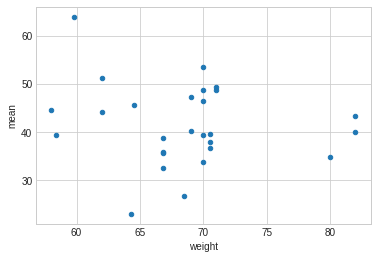

In [34]:
caffeine_vd[caffeine_vd["unit"]=="liter"][["weight","mean","value"]].plot(x="weight",y="mean",kind="scatter")

In [35]:
caffeine_vd =  infer_from_interventions(caffeine_vd, "gram")
caffeine_vd =  infer_from_outputs(caffeine_vd, "liter")

In [36]:
caffeine_vd[(caffeine_vd["group_pk"] == 601) & (caffeine_vd["value_intervention"] == 0.003)][["study","group_count","group_pk","mean","unit","unit_intervention","value_intervention"]]

,study,group_count,group_pk,mean,unit,unit_intervention,value_intervention


In [37]:
caffeine_vd.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  access  \
unit             unit_intervention                                    
liter            gram                 333          333  333     333   
                 gram / kilogram      288          288  288     288   
liter / kilogram gram                 355          355  355     355   
                 gram / kilogram      311          311  311     311   

                                    measurement_type  tissue  allowed_users  \
unit             unit_intervention                                            
liter            gram                            333     333            333   
                 gram / kilogram                 288     288            288   
liter / kilogram gram                            355     355            355   
                 gram / kilogram                 311     311            311   

                                    substance  raw_pk  interventions  ...  \
unit             unit_intervention                                    ...   
liter            gram                     333     333            333  ...   
                 gram / kilogram          288     288            288  ...   
liter / kilogram gram                     355     355            355  ...   
                 gram / kilogram          311     311            311  ...   

                                    (lean body mass, count)  \
unit             unit_intervention                            
liter            gram                                     0   
                 gram / kilogram                          0   
liter / kilogram gram                                     0   
                 gram / kilogram                          0   

                                    (lean body mass, mean)  \
unit             unit_intervention                           
liter            gram                                    0   
                 gram / kilogram                         0   
liter / kilogram gram                                    0   
                 gram / kilogram                         0   

                                    (lean body mass, sd)  \
unit             unit_intervention                         
liter            gram                                  0   
                 gram / kilogram                       0   
liter / kilogram gram                                  0   
                 gram / kilogram                       0   

                                    (lean body mass, unit)  \
unit             unit_intervention                           
liter            gram                                    0   
                 gram / kilogram                         0   
liter / kilogram gram                                    0   
                 gram / kilogram                         0   

                                    (fat weight, count)  (fat weight, mean)  \
unit             unit_intervention                                            
liter            gram                                20                  20   
                 gram / kilogram                     20                  20   
liter / kilogram gram                                20                  20   
                 gram / kilogram                     20                  20   

                                    (fat weight, se)  (fat weight, unit)  \
unit             unit_intervention                                         
liter            gram                             20                  20   
                 gram / kilogram                  20                  20   
liter / kilogram gram                             20                  20   
                 gram / kilogram                  20                  20   

                                    inferred  weight  
unit             unit_intervention                    
liter            gram                    333      95  
                 gram / kilogram         288      95  
liter / kilogram gram            

In [38]:
caffeine_vd_model = PkdbModel("caffeine_vd",destination="3-inferred")
caffeine_vd_model.data = caffeine_vd
caffeine_vd_model.save()

In [39]:
caffeine_auc_inf = measurement_type_data(complete_caffeine,"auc_inf")
caffeine_auc_inf = to_numeric(caffeine_auc_inf)
caffeine_auc_inf.groupby(["unit","unit_intervention"]).count()


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

study  output_type   pk  access  \
unit                unit_intervention                                    
gram * hour / liter gram                 243          243  243     243   
                    gram / kilogram       47           47   47      47   

                                       measurement_type  tissue  \
unit                unit_intervention                             
gram * hour / liter gram                            243     243   
                    gram / kilogram                  47      47   

                                       allowed_users  substance  raw_pk  \
unit                unit_intervention                                     
gram * hour / liter gram                         243        243     243   
                    gram / kilogram               47         47      47   

                                       interventions  ...  \
unit                unit_intervention                 ...   
gram * hour / liter gram                         243  ...   
                    gram / kilogram               47  ...   

                                       (cyp2d6 variant, count)  \
unit                unit_intervention                            
gram * hour / liter gram                                     0   
                    gram / kilogram                          0   

                                       (lean body mass, count)  \
unit                unit_intervention                            
gram * hour / liter gram                                     0   
                    gram / kilogram                          0   

                                       (lean body mass, mean)  \
unit                unit_intervention                           
gram * hour / liter gram                                    0   
                    gram / kilogram                         0   

                                       (lean body mass, sd)  \
unit                unit_intervention                         
gram * hour / liter gram                                  0   
                    gram / kilogram                       0   

                                       (lean body mass, unit)  \
unit                unit_intervention                           
gram * hour / liter gram                                    0   
                    gram / kilogram                         0   

                                       (fat weight, count)  \
unit                unit_intervention                        
gram * hour / liter gram                                 0   
                    gram / kilogram                     18   

                                       (fat weight, mean)  (fat weight, se)  \
unit                unit_intervention                                         
gram * hour / liter gram                                0                 0   
                    gram / kilogram                    18                18   

                                       (fat weight, unit)  inferred  
unit                unit_intervention                                
gram * hour / liter gram                                0       243  
                    gram / kilogram                    18        47  

[2 rows x 242 columns]

In [40]:
caffeine_auc_inf["mean"]

1557     0.03120
1652     0.00995
1669     0.02200
1767     0.06520
1768     0.06230
1777     0.06450
1793     0.06190
1815     0.06140
1833     0.05920
1836     0.05670
1837     0.05670
1904     0.02760
1915     0.06840
1957     0.06910
1962     0.06560
1964     0.06900
1970     0.06910
1976     0.02140
1979     0.02140
1991     0.02260
2000     0.02060
2020     0.02180
2023     0.02000
2037     0.02240
2038     0.02040
2040     0.02180
2055         NaN
2059         NaN
2063         NaN
2069         NaN
          ...   
11179        NaN
11185        NaN
11191        NaN
11193        NaN
11199        NaN
11205        NaN
11211        NaN
11216        NaN
11221        NaN
11223        NaN
11229        NaN
11235        NaN
11240        NaN
11244        NaN
11251        NaN
11253        NaN
11257        NaN
11333    0.00560
11339        NaN
11778        NaN
11781        NaN
11862    0.01860
11890        NaN
11899        NaN
11901        NaN
11908        NaN
11911        NaN
12144        N

In [41]:
caffeine_auc_inf =  infer_from_interventions(caffeine_auc_inf, "gram ")
caffeine_auc_inf =  infer_from_outputs(caffeine_auc_inf, "gram * hour / liter")

In [42]:
caffeine_auc_inf.groupby(["unit","unit_intervention"]).count()
#caffeine_auc_inf[["mean","value"]]

study  output_type   pk  \
unit                           unit_intervention                            
gram * hour / liter            gram                 243          243  243   
                               gram / kilogram       47           47   47   
gram * hour / liter / kilogram gram                 198          198  198   
                               gram / kilogram       40           40   40   

                                                  access  measurement_type  \
unit                           unit_intervention                             
gram * hour / liter            gram                  243               243   
                               gram / kilogram        47                47   
gram * hour / liter / kilogram gram                  198               198   
                               gram / kilogram        40                40   

                                                  tissue  allowed_users  \
unit                           unit_intervention                          
gram * hour / liter            gram                  243            243   
                               gram / kilogram        47             47   
gram * hour / liter / kilogram gram                  198            198   
                               gram / kilogram        40             40   

                                                  substance  raw_pk  \
unit                           unit_intervention                      
gram * hour / liter            gram                     243     243   
                               gram / kilogram           47      47   
gram * hour / liter / kilogram gram                     198     198   
                               gram / kilogram           40      40   

                                                  interventions  ...  \
unit                           unit_intervention                 ...   
gram * hour / liter            gram                         243  ...   
                               gram / kilogram               47  ...   
gram * hour / liter / kilogram gram                         198  ...   
                               gram / kilogram               40  ...   

                                                  (cyp2d6 variant, count)  \
unit                           unit_intervention                            
gram * hour / liter            gram                                     0   
                               gram / kilogram                          0   
gram * hour / liter / kilogram gram                                     0   
                               gram / kilogram                          0   

                                                  (lean body mass, count)  \
unit                           unit_intervention                            
gram * hour / liter            gram                                     0   
                               gram / kilogram                          0   
gram * hour / liter / kilogram gram                                     0   
                               gram / kilogram                          0   

                                                  (lean body mass, mean)  \
unit                           unit_intervention                           
gram * hour / liter            gram                                    0   
                               gram / kilogram                         0   
gram * hour / liter / kilogram gram                                    0   
                               gram / kilogram                         0   

                                                  (lean body mass, sd)  \
unit                           unit_intervention                         
gram * hour / liter            gram                                  0   
                               gram / kilogram                       0   
gram * hour / liter / kilogram gram                                  0   
                               gram / kilogram        

In [43]:
caffeine_auc_inf_model = PkdbModel("caffeine_auc_inf",destination="3-inferred")
caffeine_auc_inf_model.data = caffeine_auc_inf
caffeine_auc_inf_model.save()

In [44]:
complete_caffeine.groupby("measurement_type").count()

,study,output_type,pk,access,tissue,allowed_users,substance,raw_pk,interventions,unit,...,"(cyp2d6 variant, count)","(lean body mass, count)","(lean body mass, mean)","(lean body mass, sd)","(lean body mass, unit)","(fat weight, count)","(fat weight, mean)","(fat weight, se)","(fat weight, unit)",inferred
measurement_type,,,,,,,,,,,,,,,,,,,,,
auc_end,167,167,167,167,167,167,167,167,167,167,...,0,0,0,0,0,10,10,10,10,167
auc_inf,290,290,290,290,290,290,290,290,290,290,...,0,0,0,0,0,18,18,18,18,290
clearance,749,749,749,749,749,749,749,749,749,749,...,0,0,0,0,0,20,20,20,20,749
clearance_intrinsic,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,3
clearance_intrinsic_unbound,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,2
clearance_renal,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
clearance_unbound,7,7,7,7,7,7,7,7,7,7,...,0,0,0,0,0,0,0,0,0,7
cmax,288,288,288,288,288,288,288,288,288,288,...,0,0,0,0,0,20,20,20,20,288
concentration,197,197,197,197,197,197,197,197,197,197,...,0,10,10,10,10,12,12,12,12,197


In [45]:
caffeine_kel = measurement_type_data(complete_caffeine,"kel")
caffeine_kel = to_numeric(caffeine_kel)

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [46]:
caffeine_kel.groupby(["unit","unit_intervention"]).count()


study  output_type   pk  access  \
unit       unit_intervention                                    
1 / minute gram                 142          142  142     142   
           gram / kilogram       73           73   73      73   

                              measurement_type  tissue  allowed_users  \
unit       unit_intervention                                            
1 / minute gram                            142     142            142   
           gram / kilogram                  73      73             73   

                              substance  raw_pk  interventions  ...  \
unit       unit_intervention                                    ...   
1 / minute gram                     142     142            142  ...   
           gram / kilogram           73      73             73  ...   

                              (cyp2d6 variant, count)  \
unit       unit_intervention                            
1 / minute gram                                     0   
           gram / kilogram                          0   

                              (lean body mass, count)  (lean body mass, mean)  \
unit       unit_intervention                                                    
1 / minute gram                                     0                       0   
           gram / kilogram                          0                       0   

                              (lean body mass, sd)  (lean body mass, unit)  \
unit       unit_intervention                                                 
1 / minute gram                                  0                       0   
           gram / kilogram                       0                       0   

                              (fat weight, count)  (fat weight, mean)  \
unit       unit_intervention                                            
1 / minute gram                                 0                   0   
           gram / kilogram                     20                  20   

                              (fat weight, se)  (fat weight, unit)  inferred  
unit       unit_intervention                                                  
1 / minute gram                              0                   0       142  
           gram / kilogram                  20                  20        73  

[2 rows x 242 columns]

In [47]:
caffeine_kel =  infer_from_interventions(caffeine_kel, "gram")
caffeine_kel =  infer_from_outputs(caffeine_kel, "1/minute")

In [48]:
caffeine_kel.groupby(["unit","unit_intervention"]).count()


study  output_type   pk  access  \
unit       unit_intervention                                    
1 / minute gram                 208          208  208     208   
           gram / kilogram      207          207  207     207   

                              measurement_type  tissue  allowed_users  \
unit       unit_intervention                                            
1 / minute gram                            208     208            208   
           gram / kilogram                 207     207            207   

                              substance  raw_pk  interventions  ...  \
unit       unit_intervention                                    ...   
1 / minute gram                     208     208            208  ...   
           gram / kilogram          207     207            207  ...   

                              (cyp2d6 variant, count)  \
unit       unit_intervention                            
1 / minute gram                                     0   
           gram / kilogram                          0   

                              (lean body mass, count)  (lean body mass, mean)  \
unit       unit_intervention                                                    
1 / minute gram                                     0                       0   
           gram / kilogram                          0                       0   

                              (lean body mass, sd)  (lean body mass, unit)  \
unit       unit_intervention                                                 
1 / minute gram                                  0                       0   
           gram / kilogram                       0                       0   

                              (fat weight, count)  (fat weight, mean)  \
unit       unit_intervention                                            
1 / minute gram                                20                  20   
           gram / kilogram                     20                  20   

                              (fat weight, se)  (fat weight, unit)  inferred  
unit       unit_intervention                                                  
1 / minute gram                             20                  20       208  
           gram / kilogram                  20                  20       207  

[2 rows x 242 columns]

In [49]:
caffeine_kel_model = PkdbModel("caffeine_kel",destination="3-inferred")
caffeine_kel_model.data = caffeine_kel
caffeine_kel_model.save()

In [50]:
caffeine_vd.columns.to_list()

['study',
 'output_type',
 'pk',
 'access',
 'measurement_type',
 'tissue',
 'allowed_users',
 'substance',
 'raw_pk',
 'interventions',
 'unit',
 'calculated',
 'group_count',
 'group_name',
 'group_pk',
 'mean',
 'individual_pk',
 'individual_name',
 'value',
 'timecourse_pk',
 'time_unit',
 'time',
 'se',
 'cv',
 'sd',
 'pharmacokinetics',
 'figure',
 'max',
 'min',
 'median',
 'choice',
 'raw_pk_intervention',
 'allowed_users_intervention',
 'measurement_type_intervention',
 'access_intervention',
 'route',
 'substance_intervention',
 'unit_intervention',
 'value_intervention',
 'application',
 'time_intervention',
 'time_unit_intervention',
 'form',
 'choice_intervention',
 'min_intervention',
 'max_intervention',
 'se_intervention',
 'sd_intervention',
 'subject_type',
 'subject_pk',
 ('study', ''),
 ('subject_name', ''),
 ('species', 'choice'),
 ('species', 'count'),
 ('healthy', 'choice'),
 ('healthy', 'count'),
 ('sex', 'choice'),
 ('sex', 'count'),
 ('age', 'count'),
 ('age',

In [51]:
caffeine_vd.rename(columns={("weight","mean"):"weight"}, inplace=True)


In [52]:
#caffeine_vd[caffeine_vd["group_pk"] == 905][["study","group_count","group_pk","mean","unit","unit_intervention",'weight']]

In [53]:
caffeine_tmax[caffeine_tmax["study"]=="Carrillo2000a"]["mean"]

86     1.000000
87     1.000000
88     1.120000
89     1.000000
90     1.000000
91     1.000000
92     1.000000
93     1.170000
401    1.000000
402    1.000000
403    1.120000
404    1.000000
405    1.000000
406    1.000000
407    1.000000
408    1.170000
710    0.015504
711    0.015504
712    0.013381
713    0.011947
714    0.011947
715    0.011947
716    0.015504
717    0.018140
757    0.015504
758    0.015504
759    0.013381
760    0.011947
761    0.011947
762    0.011947
763    0.015504
764    0.018140
Name: mean, dtype: float64